In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import LineString
from shapely.geometry import Point
import branca
import folium
from folium import plugins
import matplotlib.dates as mdates
from datetime import datetime, date, timedelta, time
import importlib
import annex_codes.useful_functions_DataViz
importlib.reload(annex_codes.useful_functions_DataViz)
from annex_codes.useful_functions_DataViz import *

## Import files

In [9]:
# Full database
path_df = 'data/complete_dataset_clean_vf.csv'
# Codes of stations associated to their commercial name
path_stations_codes = "data/data_stations_codes.xlsx"
# GeoJson files that contains the geometry of the location of station
path_gdf_points = "data/data_stations_geometry.geojson"
# Weather file 
path_df_meteo = "data/Weather.csv"
# Disruptions file
path_df_disruptions = 'data/Verstoringen.xlsx'
# Results file 
path_results = "data/test_predictions_comparison_withXGBoost+disruptions_2.csv"
# Full database with cancellation 
path_df_cancellations = "data/data_NS_filtered.csv"


This are the infrastructures of our scope. One infrastructure is defined by the succession of the stations if goes through

In [10]:
# For the high-speed line, it starts between Hoofddorp and Niew-Vennep, 
# so Niew-Venney is included in the infrastructure 

infra = [
    ["Shl", "Hfd", "Rtd"], #High-Speed-line
    ["Shl", "Hfd", "Nvp", "Ssh", "Ledn", "Dvnk","Vst", "Gvm", "Laa", "Gvc"], #Slow line Schiphol-Den Haag Central
    ["Shl", "Hfd", "Nvp", "Ssh", "Ledn", "Dvnk","Vst", "Gvm", "Laa", "Gv", "Gvmw","Rsw", "Dt", "Dtcp","Sdm", "Rtd"],  #Slow line with no stop at Den Haag Central
    ["Gvc", "Gv", "Gvmw","Rsw", "Dt", "Dtcp","Sdm", "Rtd"], #Slow line Den Haag Central- Rotterdam Central
    ['Rtd', 'Hfd', 'Shl'], #High speed line (reverse)
    ['Gvc', 'Laa', 'Gvm', 'Vst', 'Dvnk', 'Ledn', 'Ssh', 'Nvp', 'Hfd', 'Shl'],  #Slow line Schiphol-Den Haag Central(reverse)
    ['Rtd','Sdm','Dtcp','Dt','Rsw','Gvmw','Gv','Laa','Gvm','Vst','Dvnk','Ledn','Ssh','Nvp','Hfd','Shl'], #Slow line with no stop at Den Haag Central (reverse)
    ['Rtd', 'Sdm', 'Dtcp', 'Dt', 'Rsw', 'Gvmw', 'Gv', 'Gvc'] #Slow line Den Haag Central- Rotterdam Central(reverse)
]

# Names of the infrastructures
labels = [
    "HighSpeed_Shl_Rtd",
    "Slow_Shl_Gvc",
    "Slow_Shl_Rtd",
    "Slow_Gvc_Rtd",
    "HighSpeed_Rtd_Shl",
    "Slow_Gvc_Shl",
    "Slow_Rtd_Shl",
    "Slow_Rtd_Gvc"
]

# Put it into a dictionnayr
infra_dict = dict(zip(labels, infra))

In [4]:
df = pd.read_csv(path_df, sep=";") 
df = convert_time_columns(df)
# --- New attribute train_type, which can be TGV, Sprinter, or Intercity
df = attribute_train_type(df)

# Map visualisations

The table intermediate_sections will give the same trips as the original dataframe, but splitted into sections that correspond to the infrastructure, in order to get the occupation of tracks

In [11]:
intermediate_sections = split_in_intermediate_sections(df,infra,infra_dict)

# New attribute for intermediate_sections : the number of tracks per section (and per direction)
intermediate_sections = attribute_n_of_tracks (intermediate_sections)

intermediate_sections = convert_delays(intermediate_sections)
# This cell takes 30 s to run


The geometries of the stations were found on Internet and downloaded through "gdf_points". To made the link with this table, we also had to download a database giving the correspondencies between stations' codes and stations' commercial names.

To display the maps, we use the geodataframe gdf_segments that contains the geometry of the sections and it's informations.

In [12]:
# Merge with the geometries of the origin and arrival stations
stations_codes = pd.read_excel(path_stations_codes)
gdf_points = gpd.read_file(path_gdf_points)

stations_geometries = get_stations_geometries(stations_codes,gdf_points,df)
gdf_intermediate_sections = geom_intermediate_sections(intermediate_sections,stations_geometries)
gdf_segments = line_geometries(gdf_intermediate_sections)

## Map of crowding

In [13]:
crowding_by_traject = intermediate_sections.groupby(["TRAJECT_infra"] )[["REALISATIE","PROGNOSE_REIZEN","AFWIJKING"]].sum().reset_index()
gdf_segments_crowding = merge_with_geometries(crowding_by_traject, gdf_segments)
gdf_segments_crowding = apply_offset_perpendicular(gdf_segments_crowding, 220)
poly_map = display_map(gdf_segments_crowding, "REALISATIE", "Crowding", gdf_segments_crowding["REALISATIE"].min(), gdf_segments_crowding["REALISATIE"].max())
poly_map

There is still this problem of untrusted notebook on Github but here is what the output looks like for the moment (basic screenshot) : 


<img src="images/crowding2.png" alt="Screenshot" width="25%">

# Map of delay per period

In [14]:
def delay_per_section(period) : 
    """ 
    It aggregates the data about delays on the sections
    Args : 
        period (string) : Name of the period of the day. It can be : Ochtendspits, Avondspits, 
        Weekend, Daluren 
    Returns : 
        gdf_segments_delay (GeoDataFrame) : Aggregated data about the delays on the sections
    """
    delay_per_period = (
        intermediate_sections.loc[intermediate_sections["DAGDEELTREIN"]==period]
        .groupby("TRAJECT_infra")
        .agg(
            mean_delay=("delay_seconds", "mean"),
        )
        .reset_index()
    )

    gdf_segments_delay = merge_with_geometries(delay_per_period,gdf_segments)
    return gdf_segments_delay


### Delay in the morning

In [16]:
gdf_segments_delay = delay_per_section("Ochtendspits")

poly_map = display_map(apply_offset_perpendicular(gdf_segments_delay, 220), 
                       "mean_delay", 
                       "Average delay (seconds)", 
                       0, 
                       200)
poly_map.save("map.html")

There is still this problem of untrusted notebook on Github but here is what the output looks like for the moment (basic screenshot) : 


<img src="images/delay_morning.png" alt="Screenshot" width="25%">

### Delay in the afternoon

In [17]:
gdf_segments_delay = delay_per_section("Avondspits")
poly_map = display_map(apply_offset_perpendicular(gdf_segments_delay, 220), 
                       "mean_delay", 
                       "Average delay (seconds)", 
                       0, 
                       200)
poly_map.save("map.html")

There is still this problem of untrusted notebook on Github but here is what the output looks like for the moment (basic screenshot) : 


<img src="images/delay_afternoon.png" alt="Screenshot" width="25%">

### Delay on off-peak hours

In [18]:
gdf_segments_delay = delay_per_section("Daluren")
poly_map = display_map(apply_offset_perpendicular(gdf_segments_delay, 220), 
                       "mean_delay", 
                       "Average delay (seconds)", 
                       0, 
                       200)
poly_map.save("map.html")

There is still this problem of untrusted notebook on Github but here is what the output looks like for the moment (basic screenshot) : 


<img src="images/delay_offpeak.png" alt="Screenshot" width="25%">

### Delay on the week-end

In [19]:
gdf_segments_delay = delay_per_section("Weekend")
poly_map = display_map(apply_offset_perpendicular(gdf_segments_delay, 220), 
                       "mean_delay", 
                       "Average delay (seconds)", 
                       0, 
                       200)
poly_map.save("map.html")

There is still this problem of untrusted notebook on Github but here is what the output looks like for the moment (basic screenshot) : 


<img src="images/delay_WE.png" alt="Screenshot" width="25%">

## Map of frequency Tuesday Morning

In [20]:
frequency_tuesday_morning = (
    intermediate_sections.loc[
        (intermediate_sections["DAGDEELTREIN"]=="Ochtendspits") & 
        (intermediate_sections['WEEK_DAG_NR']==2)
    ]
    .groupby("TRAJECT_infra")
    .size()  
    .reset_index(name="count") 
)
gdf_segments_tuesday = merge_with_geometries(frequency_tuesday_morning,gdf_segments)
gdf_segments_tuesday["frequency"] = gdf_segments_tuesday["count"]/2.5/4

gdf_segments_tuesday = apply_offset_perpendicular(gdf_segments_tuesday, 220)
poly_map = display_map(gdf_segments_tuesday, "frequency", "Frequency (trains per hour)", 2, 20)
poly_map.save("map.html")

There is still this problem of untrusted notebook on Github but here is what the output looks like for the moment (basic screenshot) : 


<img src="images/frequency_tuesday.png" alt="Screenshot" width="25%">

## Map of frequency Saturday evening

In [21]:
frequency_saturday = (
    intermediate_sections.loc[
        (intermediate_sections['PLANTIJD_VERTREK']<pd.to_timedelta("16:00:00")) & 
        (intermediate_sections['PLANTIJD_VERTREK']>pd.to_timedelta("15:00:00")) & 
        (intermediate_sections['WEEK_DAG_NR']==6)
    ]
    .groupby("TRAJECT_infra")
    .size()  
    .reset_index(name="count")
)
gdf_segments_saturday = merge_with_geometries(frequency_saturday,gdf_segments)
gdf_segments_saturday["frequency"] = gdf_segments_saturday["count"]/4

gdf_segments_saturday = apply_offset_perpendicular(gdf_segments_saturday, 220)
poly_map = display_map(gdf_segments_saturday, "frequency", "Frequency (trains per hour)", 2, 20)
poly_map.save("map.html")

There is still this problem of untrusted notebook on Github but here is what the output looks like for the moment (basic screenshot) : 


<img src="images/frequency_saturday.png" alt="Screenshot" width="25%">

## Average deviation per route (map)

In [22]:
average_deviations = intermediate_sections.loc[intermediate_sections["REALISATIE"]>1].groupby("TRAJECT_infra").agg({
                        "REALISATIE": "mean",
                        "PROGNOSE_REIZEN": "mean",
                        "AFWIJKING": lambda x: x.abs().mean()
}).reset_index()
                        
gdf_average_deviations = merge_with_geometries(average_deviations,gdf_segments)
gdf_average_deviations = apply_offset_perpendicular(gdf_average_deviations, 220)

In [17]:
poly_map = display_map(
    gdf_average_deviations, 
    "AFWIJKING", 
    'Average deviation per section', 
    gdf_average_deviations["AFWIJKING"].min(), 
    gdf_average_deviations["AFWIJKING"].max())

poly_map.save("map.html")

There is still this problem of untrusted notebook on Github but here is what the output looks like for the moment (basic screenshot) : 


<img src="images/deviation.png" alt="Screenshot" width="25%">

# Average deviation per route (bar chart)

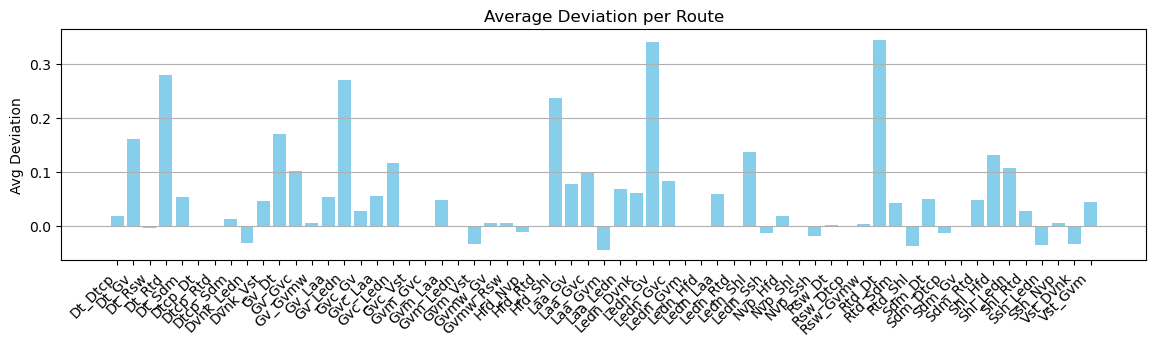

In [23]:
# Group by route
route_stats = df.loc[df["REALISATIE"]>1].groupby("TRAJECT").agg({
    "REALISATIE": "mean",
    "PROGNOSE_REIZEN": "mean",
    "AFWIJKING": "mean"
}).reset_index()

plot_average_deviation_per_route(route_stats)

# Quality of previsions through the day

This figure shows the comparison between the average number of expected passengers and the average number measured through the day

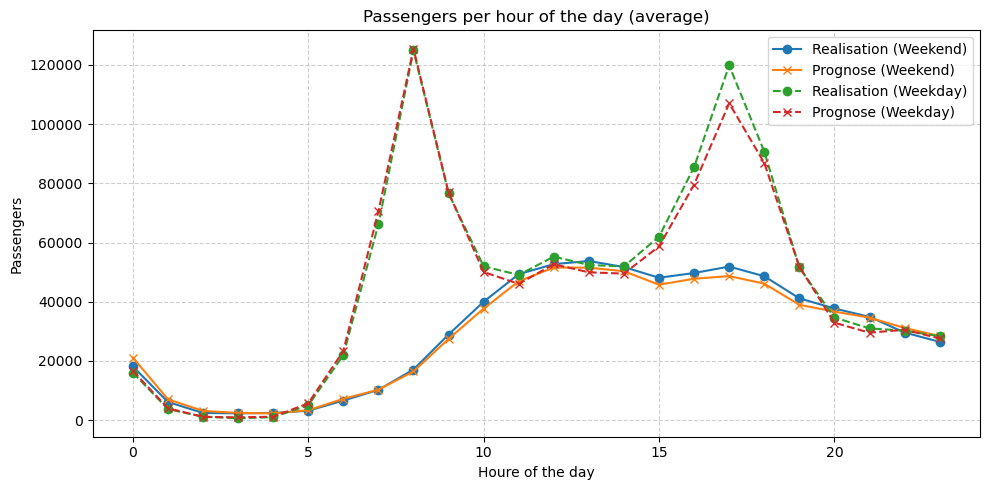

In [24]:
df_filtered = df.copy()

if not pd.api.types.is_timedelta64_dtype(df_filtered['UITVOERTIJD_AANKOMST']):
    df_filtered['UITVOERTIJD_AANKOMST'] = pd.to_timedelta(df_filtered['UITVOERTIJD_AANKOMST'])
df_filtered['UUR'] = df_filtered['UITVOERTIJD_AANKOMST'].dt.seconds // 3600

df_filtered['DAGTYPE'] = df_filtered['DAGNR'] % 7
df_filtered['IS_WEEKEND'] = df_filtered['DAGTYPE'].isin([1, 2])

weekend = df_filtered[df_filtered['IS_WEEKEND']]
weekday = df_filtered[~df_filtered['IS_WEEKEND']]

n_weekend_days = weekend['DAGNR'].nunique()
n_weekday_days = weekday['DAGNR'].nunique()

weekend_sum = weekend.groupby('UUR')[['REALISATIE', 'PROGNOSE_REIZEN']].sum() / n_weekend_days
weekday_sum = weekday.groupby('UUR')[['REALISATIE', 'PROGNOSE_REIZEN']].sum() / n_weekday_days

plot_day_pattern (weekday_sum,weekend_sum)


# Weekly patterns

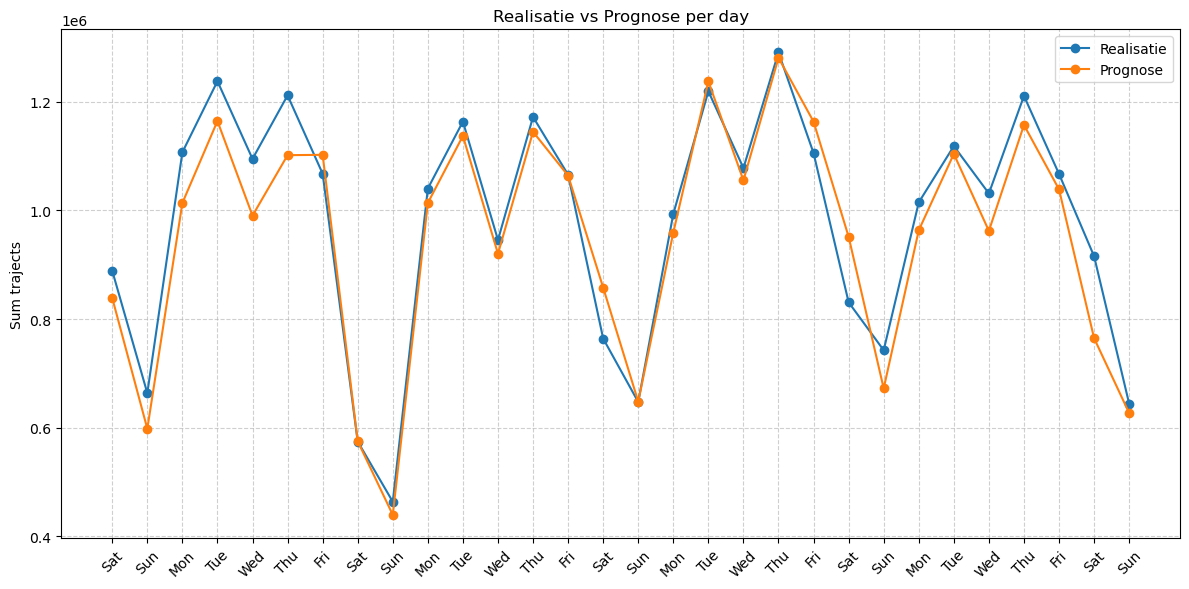

Absolute gemiddelde afwijking: 5.43%


In [25]:
df_filtered = df.copy()
dag_totaal = (df_filtered.groupby("DAGNR")[["REALISATIE", "PROGNOSE_REIZEN"]].sum())
dag_totaal["AFWIJKING_%"] = ((dag_totaal["REALISATIE"] - dag_totaal["PROGNOSE_REIZEN"])/ dag_totaal["PROGNOSE_REIZEN"]) * 100

dag_totaal_afwijking = dag_totaal["AFWIJKING_%"].abs()

days = ["Sat", "Sun", "Mon", "Tue", "Wed", "Thu", "Fri"]
day_labels = [days[(d - 1) % 7] for d in dag_totaal.index]

plot_week_pattern(dag_totaal, day_labels) 

#plot_week_deviation (dag_totaal,  dag_totaal_afwijking, day_labels)

Deviation = dag_totaal_afwijking.abs().mean()
print(f"Absolute gemiddelde afwijking: {Deviation:.2f}%")

#display (dag_totaal)

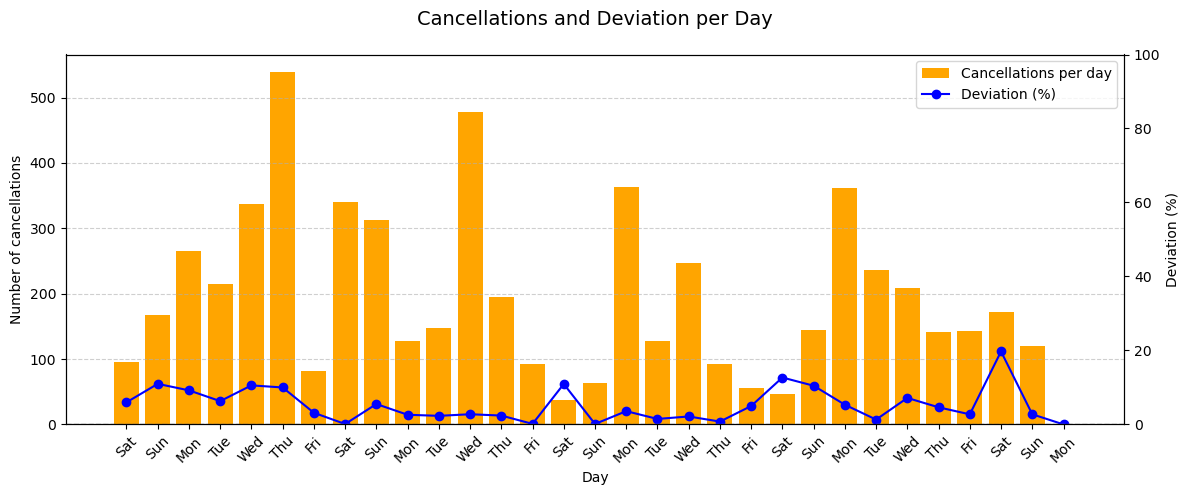

In [26]:
dag_totaal_afwijking_graph = dag_totaal_afwijking
df_cancel = pd.read_csv(path_df_cancellations, sep=";")
df_cancellations_per_day = ( df_cancel[df_cancel["Cancelled"] == True] .groupby("DAGNR") .size() .reindex(range(1, 32), fill_value=0))

days = ["Sat", "Sun", "Mon", "Tue", "Wed", "Thu", "Fri"]
day_labels = [days[(d - 1) % 7] for d in range(1, 32)]

combined = pd.DataFrame({"CANCELLATIONS": df_cancellations_per_day, "AFWIJKING_%": dag_totaal_afwijking_graph}).fillna(0)
plot_day_cancellation_deviation(combined, day_labels)


# Average delay on all of the network 

To only get 1 delay per train, two approaches can be used. Lets take the example of a train running from Shl to Gvc. Let's say that this train has a 11min38 delay from Shl to Hfd, 11min43 delay from Hfd to Ledn, and a 11min35 delay from Ledn to Gvc (it catches up a little on the last section). 
- First approach : we take the maximum delay encountered by the train. For this example, it should be 11min43
- Second approach : we take te final delay of the train at it's final station. For this example, it should be 11min35.

I think that the second approach is the most relevant one, but the two of them are written in the code, and one just need to comment/uncomment the two lines.

In [27]:
df_delay_per_train = get_1_delay_per_train(df)

for period in ["Ochtendspits", "Avondspits", "Daluren","Weekend"] : 
    mean_delay_period = mean_delays_per_period(period, df_delay_per_train)
    print(f"Mean delay in the morning peak: {mean_delay_period.hour} hour(s) {mean_delay_period.minute} minute(s) {mean_delay_period.second} second(s)")


Mean delay in the morning peak: 0 hour(s) 1 minute(s) 8 second(s)
Mean delay in the morning peak: 0 hour(s) 1 minute(s) 35 second(s)
Mean delay in the morning peak: 0 hour(s) 1 minute(s) 18 second(s)
Mean delay in the morning peak: 0 hour(s) 1 minute(s) 22 second(s)


# Influence of small delays


## Propagation of delays

We want to know, if a train is delayed, what is the influence of the trains after occupying the same infrastructure. For this purpose, we define a new attribute "order infrastructure" on intermediate sections.

The, we create an attribute that recognize initial delays, still in the function identify_impact_of_initial_delays. 

Rules for being an initial delay : 
- The last 3 trains were delayed of 0 minutes
- The train is 3 times more delayed than any last 3 train

In [28]:
small_delays = intermediate_sections.copy()
small_delays['UITVOERTIJD_VERTREK_dt'] = small_delays['UITVOERTIJD_VERTREK']
    
# To make accurate calculations, we decide that a day starts at 5 a.m., so we need to "change the day
# number" of train running from 0 a.m. to 5 a.m. 
small_delays.loc[small_delays['UITVOERTIJD_VERTREK_dt'] < pd.Timedelta(hours=5), 'UITVOERTIJD_VERTREK_dt'] -= pd.Timedelta(days=1)
    
# We sort the lines with the same order as they occupy the infrastructures
small_delays['ORDER_ON_INFRA'] = (
        small_delays
        .sort_values(by=['DAGNR', 'station1', 'station2', 'UITVOERTIJD_VERTREK_dt'])
        .groupby(['DAGNR', 'station1', 'station2'])
        .cumcount() + 1     
    )

small_delays = identify_initial_delays(small_delays)

# This cell is long to run


As an example, train 2280 showed below is delayed of 75 s initially. 
We see here the propagation of the delays on the following trains

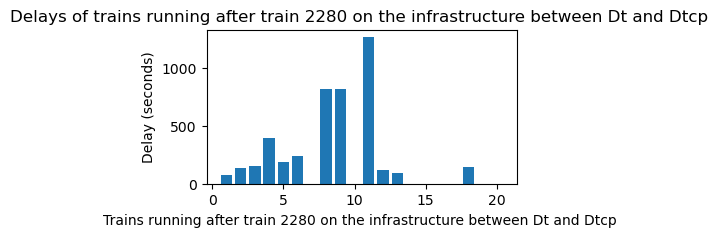

In [29]:
i = 0 # index in table
# We select the 20 next trains running on the same infra after this train
select_20_following_trains = select_following_trains(i,small_delays,20)
plot_propagation_of_delays_unique(i, select_20_following_trains,small_delays)

Now we represent the average propagation of delays (before, we would only focus on a specific train).
On this figure, for all the trains that are delayed of approximately 6 minutes (between 5 and 7 min) at their initial delay (as defined at the beginning of this section), we can see the approximate delay for the trains running after them on the same infra

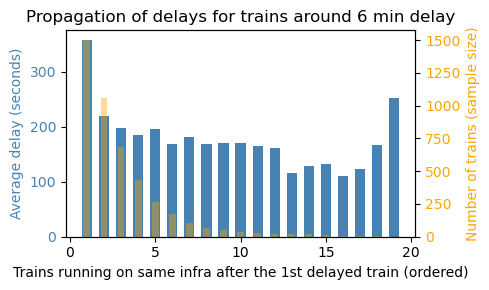

In [30]:
minute = 6

interval = [60 * minute - 60, 60 * minute + 60]
# Select all the trains initially delayed of 6 minutes
initially_delayed_trains = small_delays.loc[
        (small_delays["delay_seconds"] >= interval[0]) &
        (small_delays["delay_seconds"] < interval[1]) &
        (small_delays["initial_delay"] == True)
    ]

# Select all the trains following these initially delayed trains
following_trains = select_following_trains_bis(minute, small_delays,initially_delayed_trains,20)

df_agg = (
        following_trains.groupby("order_of_apparition")["delay_seconds_other"]
        .agg(["mean", "count"])
        .reset_index()
        .rename(columns={
            "order_of_apparition": "Order of apparition on infra",
            "mean": "mean_delay_seconds",
            "count": "n_obs"
        })
    )

plot_propagation_of_delays(minute, df_agg)

The following graph synthetises the previous results for all small delays (from 3 to 10 minutes). The point isn't plot when the sample size is inferior to 8.

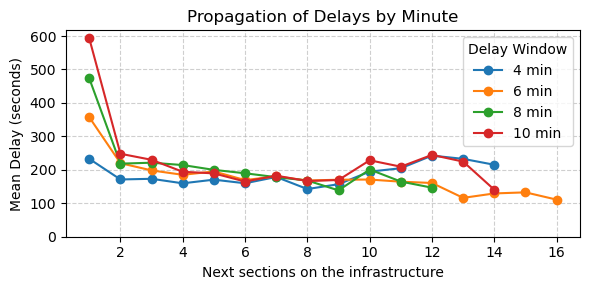

In [31]:
plt.figure(figsize=(6, 3))

for minute in [4,6,8,10]:
    df_agg = agg_propagation_of_delays(minute, small_delays, 8)
    plt.plot(
        df_agg['ORDER_ON_INFRA_INDEX'],
        df_agg["mean_delay_seconds"],
        label=f"{minute} min",      
        marker='o',             
        linestyle='-',             
        linewidth=1.5              
    )

plt.xlabel("Next sections on the infrastructure")
plt.ylabel("Mean Delay (seconds)")
plt.title("Propagation of Delays by Minute")
plt.legend(title="Delay Window")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.ylim(bottom=0)
plt.show()


## Crowding of trains after small delays

We want to know, when a train is delayed before it's terminus station, if it will be more crowded than forecasted on the rest of it's trip We want to know, when a train is delayed before it's terminus station, if it will be more crowded than forecasted on the rest of it's trip 

In [32]:
# Creation of a new attribute : IS_TERMINUS 

df_is_terminus = df.copy()
df_is_terminus['IS_TERMINUS'] = (
    df_is_terminus.groupby(['DAGNR', 'BEWEGINGNUMMER'])
    .cumcount(ascending=False) == 0
)

df_is_terminus=convert_delays(df_is_terminus)

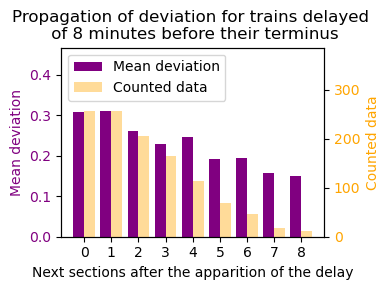

In [33]:
minute =8
# This list contains the indexes of the first delays
index_first_delays = list_index_first_delays (minute,df_is_terminus)
# This dataframe keeps the evolution of the journeys of trains after they encountered their first delay
df_evolution_journey = evolution_journey(df_is_terminus, index_first_delays)

# Order the rest of the services after the appartition of the delay
df_evolution_journey['ORDER_ON_SERVICE'] = (
    df_evolution_journey
    .groupby(['DAGNR', 'BEWEGINGNUMMER'])
    .cumcount() 
)

plot_propagation_of_deviation(df_evolution_journey, minute)

And here is the comparison to the evolution of deviation of all the trains, without considering their delays

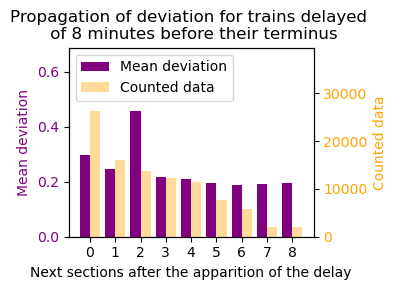

In [34]:
df_is_terminus['ORDER_ON_SERVICE'] = (
    df_is_terminus
    .groupby(['DAGNR', 'BEWEGINGNUMMER'])
    .cumcount()  
)

plot_propagation_of_deviation(df_is_terminus.loc[(~ pd.isna(df_is_terminus["delay_seconds"]))],minute)

### Separate on the infrastructures

Only on the slow line between Rotterdam Central and Shiphol

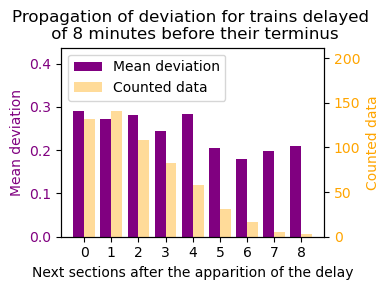

In [35]:
plot_propagation_of_deviation(df_evolution_journey.loc[df_evolution_journey["global_infra_name"].isin(['Slow_Rtd_Shl','Slow_Rtd_Gvc','Slow_Gvc_Shl'])], 
                             minute)



Only on the slow lines between Schiphol and Rotterdam Central

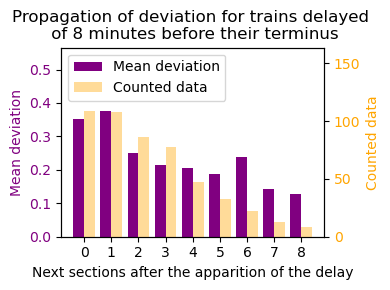

In [36]:
plot_propagation_of_deviation(df_evolution_journey.loc[df_evolution_journey["global_infra_name"].isin(['Slow_Shl_Rtd','Slow_Gvc_Rtd','Slow_Shl_Gvc'])],
                             minute)


## People changing their journey themselves

We want to check if, for trains with small delays, people board on other trains departing from the next station, instead of waiting for their train to arrive.

To check this, we summarize all the trains delayed from a certain amount of time, for example 10 minutes. Then, we look at the trains leaving from the next arrival stations during these 10 minutes. If the deviation of those trains is significantly high, it means that people, instead of waiting for their train to arrive, will board onto another one (for example, a Sprinter even if it is longer than the IC they were expecting).

In [30]:
def people_changing_their_journey(minute=10) : 
    #Select all the lines from the main dataframe which have approximately a 10 minute delay
    considered_delayed_trains = list_index_first_delays(minute, df_is_terminus)
    #Select, for all those trains, the trains that were leaving from next station at the same time
    trains_leaving_during_delays = select_trains_leaving_during_delays(considered_delayed_trains, df_is_terminus,minute)
    return trains_leaving_during_delays

for minute in range(3,11) : 
    mean_deviation_with_delay = people_changing_their_journey(minute)["AFWIJKING"].abs().mean()
    print(f"The mean deviation when train are delayed of {minute} minutes is {round(mean_deviation_with_delay,4)*100}%")



The mean deviation when train are delayed of 3 minutes is 26.479999999999997%
The mean deviation when train are delayed of 4 minutes is 24.63%
The mean deviation when train are delayed of 5 minutes is 23.16%
The mean deviation when train are delayed of 6 minutes is 24.63%
The mean deviation when train are delayed of 7 minutes is 23.24%
The mean deviation when train are delayed of 8 minutes is 26.08%
The mean deviation when train are delayed of 9 minutes is 20.93%
The mean deviation when train are delayed of 10 minutes is 18.5%


In [31]:
mean_deviation = df_is_terminus["AFWIJKING"].abs().mean()
print(f"The mean deviation is {round(mean_deviation,4)*100}%")


The mean deviation is 27.189999999999998%


We see that people don't change train in a significative way instead of waiting for their late train to arriveWe see that people don't change train in a significative way instead of waiting for their late train to arrive. Or maybe they do, but we can't evaluate it with the attribute AFWIJKING.

# Influence of weather conditions

In [37]:
df_meteo = pd.read_csv(path_df_meteo)

df_meteo = df_meteo.rename(columns={
    '    R': 'R', 
    '    O': 'O',
    '   FH': 'FH',
    '   RH': 'RH'  
})

# In the documentation of the weather data, it is said that when a value of RH is negative, it is 
# because it is inferior to 0.1 cm
df_meteo["RH"] = df_meteo["RH"].astype(float)
df_meteo.loc[df_meteo["RH"]<0,"RH"] *= -0.5

# Associate to the train services the weather conditions occuring at the same time

df_merge_meteo = df.loc[df["REALISATIE"]>1].copy() 
df_merge_meteo['PLANTIJD_VERTREK_hour']=df_merge_meteo['PLANTIJD_VERTREK'].dt.components.hours
df_merge_meteo= pd.merge(df_merge_meteo, 
                         df_meteo[['# STN', 'Day', 'HH', 'FH', 'RH', 'R', 'O']], 
                         left_on = ['DAGNR', 'PLANTIJD_VERTREK_hour'], 
                         right_on = ['Day', 'HH'])

df_merge_meteo = df_merge_meteo.loc[(df_merge_meteo['Cancelled']==False) &(df_merge_meteo['ExtraTrain']==False)]
df_merge_meteo= convert_delays(df_merge_meteo)


Mean deviation based on different factors

In [38]:
def mean_deviation_with_weather(condition,df_merge_meteo) : 
    mask = df_merge_meteo.loc[condition]
    mean_deviation = round(mask['AFWIJKING'].abs().mean(),3)*100
    return mean_deviation

# Presence of rain
print (f"Average deviation with some rain (heavy or not): {mean_deviation_with_weather(df_merge_meteo['R']==1, df_merge_meteo)}%")
#Presence of thunder 
print (f"Average deviation with some thunder : {mean_deviation_with_weather(df_merge_meteo['O']==1, df_merge_meteo)}%")
# Without rain or thunder 
print (f"Average deviation without rain or thunder : {mean_deviation_with_weather(df_merge_meteo['R']==0, df_merge_meteo)}%")
# Total 
print (f"Average deviation in general : {round(df_merge_meteo[(df_merge_meteo['Cancelled']==False) &(df_merge_meteo['ExtraTrain']==False)]['AFWIJKING'].abs().mean(),3)*100}%")
# With heady wind : 
print (f"Average deviation with heavy wind : {mean_deviation_with_weather(df_merge_meteo['Gusts_flag']==1, df_merge_meteo)}%")
# With heavy rain
print (f"Average deviation with heavy rain : {mean_deviation_with_weather(df_merge_meteo['Heavy_Rain_flag']==1, df_merge_meteo)}%")

Average deviation with some rain (heavy or not): 21.5%
Average deviation with some thunder : 21.2%
Average deviation without rain or thunder : 23.200000000000003%
Average deviation in general : 22.900000000000002%
Average deviation with heavy wind : 20.5%
Average deviation with heavy rain : 20.4%


Graph with the amount of rain, the average delay, the average deviation

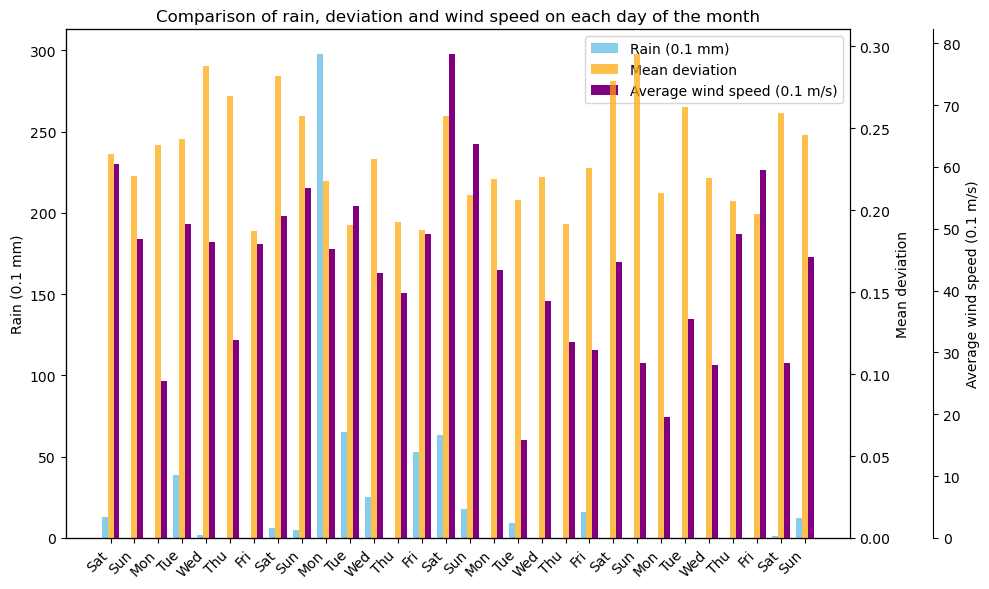

In [39]:
# Aggregate the data about deviations & delays per day, from the main df
df_meteo_graph = df_merge_meteo.groupby("DAGNR").agg({
    "AFWIJKING": lambda x: x.abs().mean(),
    "REALISATIE" : "sum", 
    "delay_seconds": "mean"
})

# Aggregate the data about climate conditions per day, from the weather df
df_meteo_bis = df_meteo.groupby("Day").agg({"RH" : 'sum',
                                           "FH": 'mean'})

df_meteo_graph = pd.merge(df_meteo_graph, 
                          df_meteo_bis, 
                          left_index=True, 
                          right_on= "Day")

week_days = [ "Fri", "Sat", "Sun", "Mon", "Tue", "Wed", "Thu"]
df_meteo_graph["Weekday"] = [
    f"{week_days[i % 7]}" for i in df_meteo_graph.index
]

plot_rain_deviation_wind(df_meteo_graph)

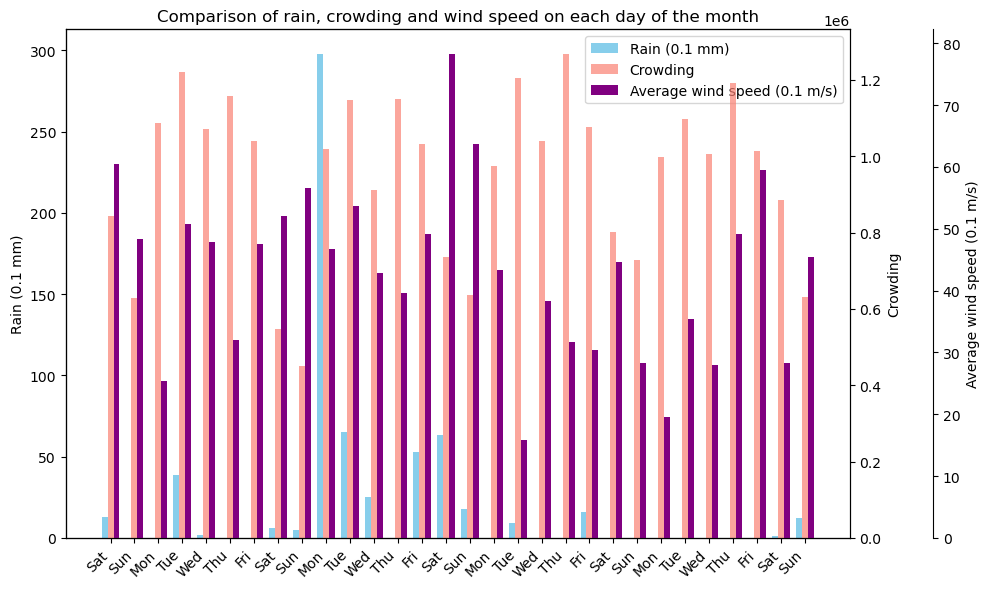

In [40]:
plot_rain_crowding_wind(df_meteo_graph) 


## Focus on one specific day 

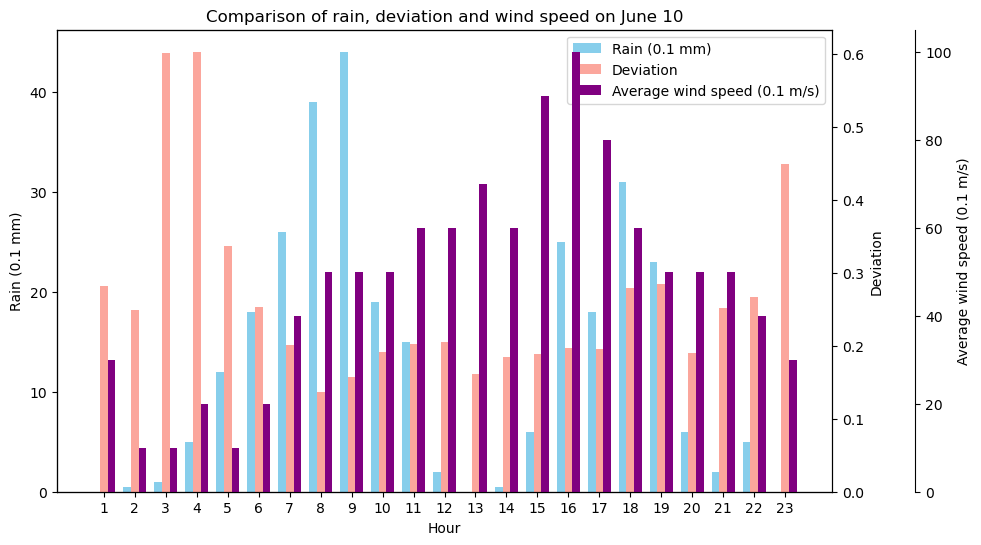

In [41]:
day=10
df_june_10 = df_merge_meteo.loc[df_merge_meteo["DAGNR"]==day].groupby("HH").agg({
    "RH" : "first",
    "FH" : "first", 
    "AFWIJKING": lambda x: x.abs().mean(), 
    "REALISATIE" : "sum"})

plot_rain_deviation_wind_specific_day(df_june_10,day)

# Disruptions patterns 

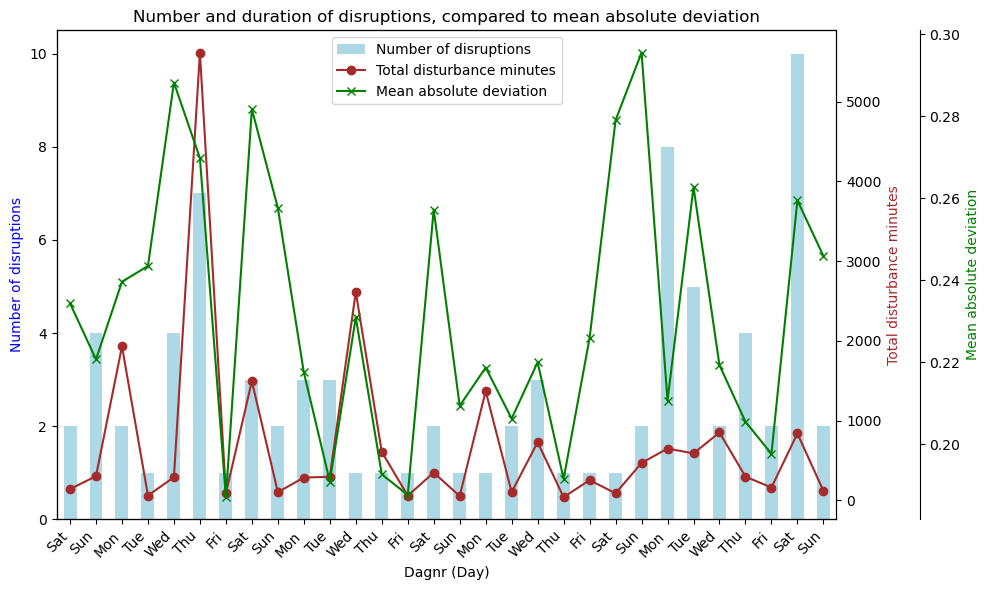

In [42]:
df_disruptions = pd.read_excel(path_df_disruptions)

stations = [
    "Dvnk", "Dt", "Dtcp", "Gvc", "Gv", "Laa", "Gvm", "Gvmw", 
    "Hfd", "Ledn", "Nvp", "Rsw", "Rtd", "Ssh", "Sdm", "Shl", "Vst"
]

df_disruptions_filter = df_disruptions.loc[((df_disruptions['DIENSTREGELPUNT_VAN'].isin(stations))|
                                    (df_disruptions['DIENSTREGELPUNT_NAAR'].isin(stations)))&
                                    ((df_disruptions['BEWEGINGNUMMER'].isin(df['BEWEGINGNUMMER'].unique().tolist()))|
                                    (df_disruptions['BEWEGINGNUMMER']==-2))]

df_disruptions_plot = (
    df_disruptions_filter
    .groupby("Dagnr")
    .agg({'KLANTHINDERINMINUTEN':"sum", 
         "KLANTHINDERNAAM" : "size"})
).reset_index()

week_days = ["Sat", "Sun", "Mon", "Tue", "Wed", "Thu","Fri"]

df_disruptions_plot["Weekday"] = [
    f"{week_days[i % 7]}" for i in df_disruptions_plot.index
]

plot_disruptions_patterns (df_disruptions_plot, df_meteo_graph)


# Models results

In [43]:
df_results = pd.read_csv(path_results,sep=",")

# --- Disrupted-only metrics (delay != 'No delay (0-1 min)' OR disruption != 'No Disruption') ---

NO_DELAY_LABEL = 'no delay (0-1 min)'
NO_DISR_LABEL  = 'no disruption'

def disrupted_mask(idx):
    dcat = df_results.loc[idx, "Delays (cat)"].astype(str).str.strip().str.lower() if "Delays (cat)" in df_results.columns else "nan"
    disc = df_results.loc[idx, "Disruptions (cat)"].astype(str).str.strip().str.lower() if "Disruptions (cat)" in df_results.columns else "nan"
    return (dcat != NO_DELAY_LABEL) | (disc != NO_DISR_LABEL)

dis_mask_test = disrupted_mask(df_results.index).values
n_dis = int(dis_mask_test.sum())
print(f"\nDisrupted runs in TEST (OR rule): {n_dis} / {len(dis_mask_test)}")


# Add new columsn for the deviation of each model : 
for column in ['OPERATOR_PRED','LINEAR_PRED', 'MLP_PRED', 'XGBOOST_PRED'] : 
        df_results[f"deviation_{column}"] = np.abs(df_results[column]- df_results["REALISATIE"])
    
weekdays = [ "Mon", "Tue", "Wed", "Thu","Fri", "Sat", "Sun"]
df_results["Weekday"]  = [
        f"{weekdays[(i-3) % 7]}, {i}" for i in df_results["DAGNR"].values
    ]
    
df_results['PLANTIJD_VERTREK']= pd.to_timedelta(df_results['PLANTIJD_VERTREK'].str.split('.').str[0], errors='coerce')
df_results["hour"] = df_results['PLANTIJD_VERTREK'].dt.components['hours']

df_results_disrupt = df_results[dis_mask_test]




Disrupted runs in TEST (OR rule): 7767 / 23459


## Absolute difference |Prevision - Realisation|

### Overall data

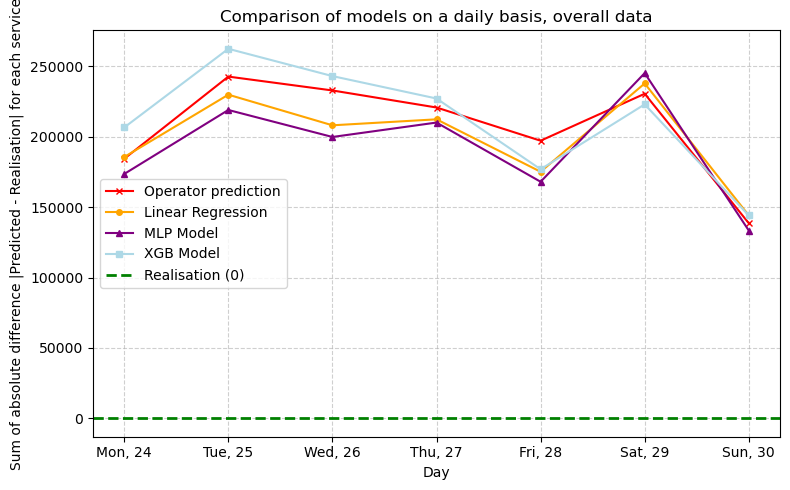

In [44]:
df_results_day = df_results.groupby("DAGNR").agg({
    'deviation_OPERATOR_PRED' : "sum", 
    'deviation_LINEAR_PRED' : "sum", 
    'deviation_MLP_PRED' :"sum", 
    'deviation_XGBOOST_PRED' : "sum", 
    "Weekday" : "first",
}) 


plot_model_comparison (df_results_day,
                       "Weekday", 
                       "Comparison of models on a daily basis, overall data", 
                       "Day", 
                      4, 
                      1.5)


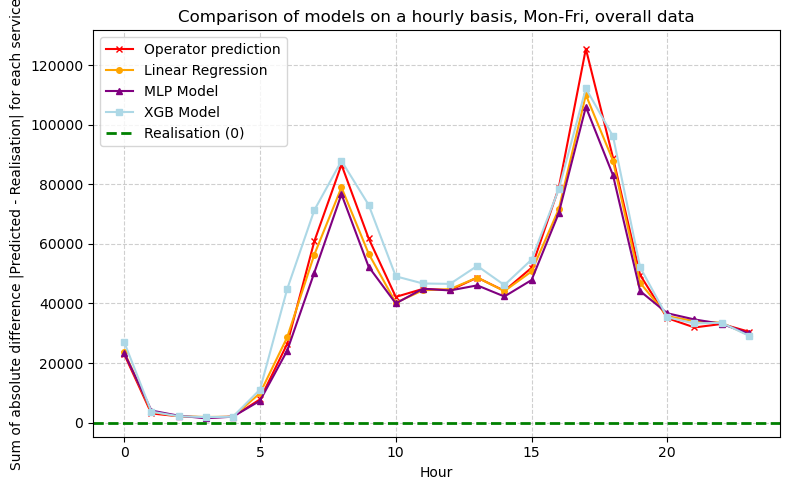

In [45]:
df_results_hour = df_results.loc[df_results["DAGNR"].isin([24,25,26,27,28])].groupby("hour").agg({
    'deviation_OPERATOR_PRED' : "sum", 
    'deviation_LINEAR_PRED' : "sum", 
    'deviation_MLP_PRED' :"sum", 
    'deviation_XGBOOST_PRED' : "sum", 
    "hour" : "first",
}) 

plot_model_comparison (df_results_hour, 
                       "hour", 
                       "Comparison of models on a hourly basis, Mon-Fri, overall data", 
                       "Hour", 
                      4, 
                      1.5)

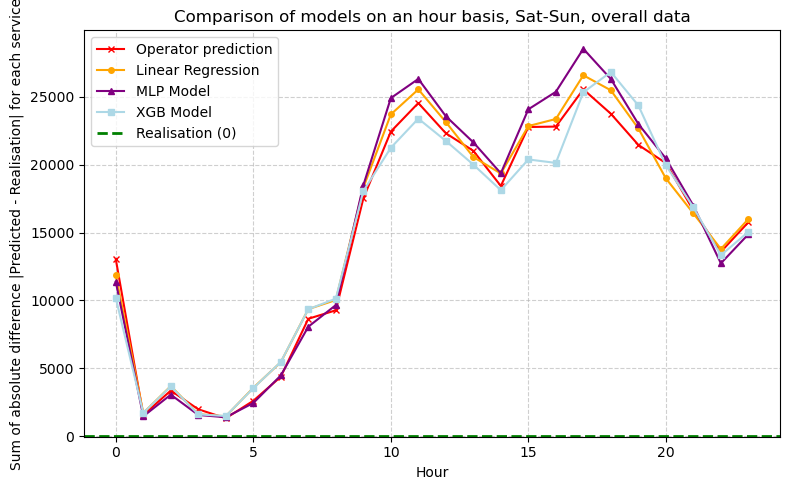

In [46]:
df_results_hour = df_results.loc[df_results["DAGNR"].isin([29,30])].groupby("hour").agg({
    'deviation_OPERATOR_PRED' :"sum", 
    'deviation_LINEAR_PRED' : "sum", 
    'deviation_MLP_PRED' :"sum", 
    'deviation_XGBOOST_PRED' :"sum", 
    "hour" : "first",
}) 

plot_model_comparison (df_results_hour,
                       "hour", 
                       "Comparison of models on an hour basis, Sat-Sun, overall data",
                       "Hour", 
                      4, 
                      1.5)


### Disrupted data

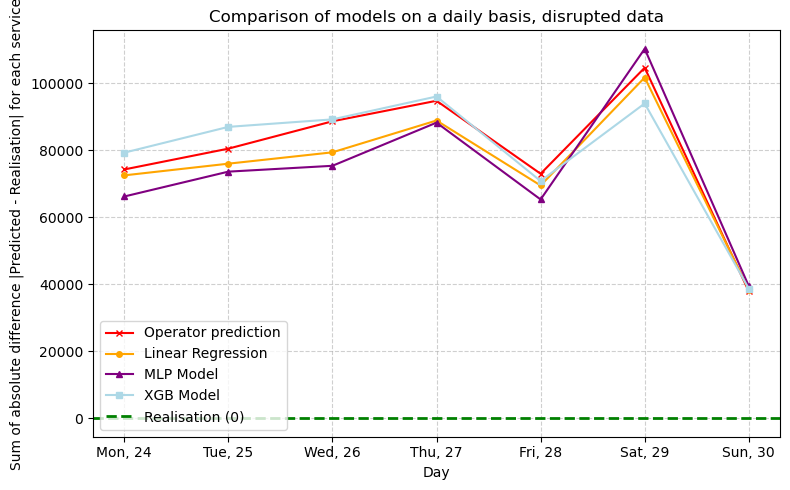

In [47]:
df_results_day_disrupt = df_results_disrupt.groupby("DAGNR").agg({
    'deviation_OPERATOR_PRED' : "sum", 
    'deviation_LINEAR_PRED' : "sum", 
    'deviation_MLP_PRED' :"sum", 
    'deviation_XGBOOST_PRED' : "sum", 
    "Weekday" : "first",
}) 


plot_model_comparison (df_results_day_disrupt,
                       "Weekday", 
                       "Comparison of models on a daily basis, disrupted data", 
                       "Day", 
                      4, 
                      1.5)

## Total train occupancy

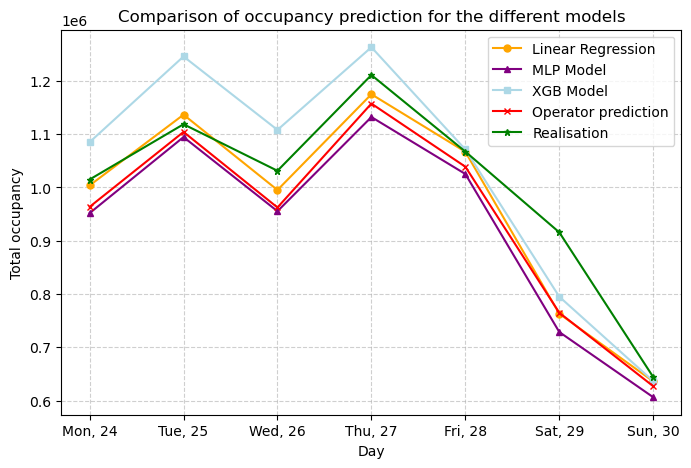

In [48]:
df_results_day_crowding = df_results.groupby("DAGNR").agg({
    'REALISATIE' : "sum",
    'OPERATOR_PRED' : "sum", 
    'LINEAR_PRED' : "sum", 
    'MLP_PRED' :"sum", 
    'XGBOOST_PRED' : "sum", 
    "Weekday" : "first",
}) 

plot_model_comparison_occupancy (df_results_day_crowding, 
                                 "Weekday", 
                                 "Comparison of occupancy prediction for the different models", 
                                 "Day", 
                                5, 
                                1.5)


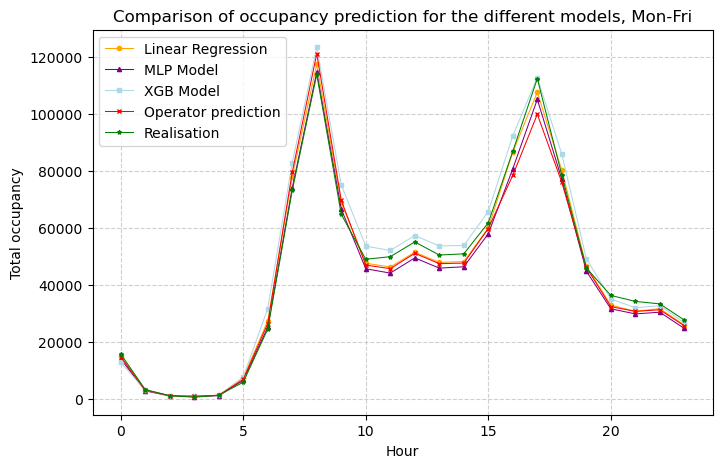

In [49]:
df_results_hour = df_results.loc[df_results["DAGNR"].isin([24,25,26,27,28])].groupby("hour").agg({
    'REALISATIE' : lambda x : x.sum()/5 ,
    'OPERATOR_PRED' : lambda x : x.sum()/5 , 
    'LINEAR_PRED' :lambda x : x.sum()/5 , 
    'MLP_PRED' :lambda x : x.sum()/5 , 
    'XGBOOST_PRED' :lambda x : x.sum()/5 , 
    "hour" : "first",
}) 

plot_model_comparison_occupancy (df_results_hour, 
                                 "hour", 
                                 "Comparison of occupancy prediction for the different models, Mon-Fri", 
                                 "Hour", 
                                3, 
                                0.75)



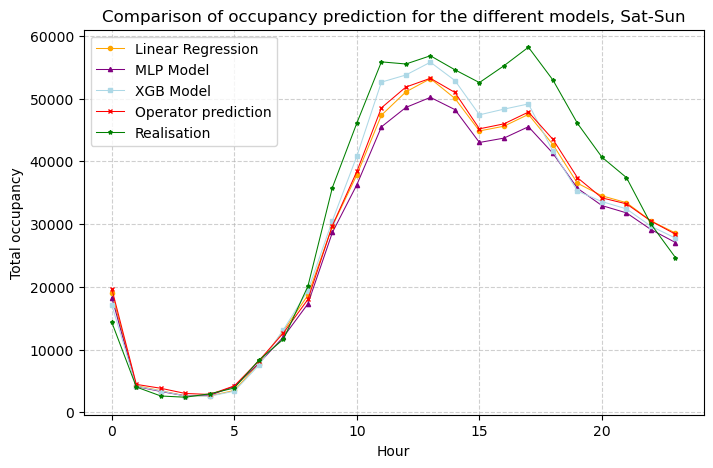

In [50]:
df_results_hour = df_results.loc[df_results["DAGNR"].isin([29,30])].groupby("hour").agg({
    'REALISATIE' :  lambda x : x.sum()/2,
    'OPERATOR_PRED' : lambda x : x.sum()/2, 
    'LINEAR_PRED' : lambda x : x.sum()/2, 
    'MLP_PRED' :lambda x : x.sum()/2, 
    'XGBOOST_PRED' : lambda x : x.sum()/2, 
    "hour" : "first",
}) 

plot_model_comparison_occupancy (df_results_hour,
                                 "hour", 
                                 "Comparison of occupancy prediction for the different models, Sat-Sun", 
                                 "Hour", 
                                3, 
                                0.75)
